In [35]:
import pandas as pd

df = pd.read_csv('data/DATASET_ic50_cleaned_compounds.csv')

In [36]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Generate Murcko scaffolds for each molecule
def get_murcko_scaffold(smiles):
    """Extract Murcko scaffold from SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

# Apply scaffold generation
print("Generating Murcko scaffolds...")
df['scaffold'] = df['smiles'].apply(get_murcko_scaffold)

# Filter out compounds where scaffold generation failed
df_valid = df[df['scaffold'].notna()].copy()

print(f"Compounds with valid scaffolds: {len(df_valid):,} / {len(df):,}")
print(f"Failed scaffold generation: {len(df) - len(df_valid):,}")


Generating Murcko scaffolds...
Compounds with valid scaffolds: 422 / 422
Failed scaffold generation: 0


In [37]:
from collections import Counter

# Count compounds per scaffold
scaffold_counts = Counter(df_valid['scaffold'])

print(f"Total unique scaffolds: {len(scaffold_counts):,}")
print(f"\nScaffold distribution:")
print(f"  Singletons (1 compound): {sum(1 for c in scaffold_counts.values() if c == 1):,}")
print(f"  Small series (2-5): {sum(1 for c in scaffold_counts.values() if 2 <= c <= 5):,}")
print(f"  Medium series (6-20): {sum(1 for c in scaffold_counts.values() if 6 <= c <= 20):,}")
print(f"  Large series (>20): {sum(1 for c in scaffold_counts.values() if c > 20):,}")

# Show top 10 most common scaffolds
print(f"\nTop 10 scaffolds by compound count:")
for scaffold, count in scaffold_counts.most_common(10):
    print(f"  {count:4d} compounds: {scaffold[:50]}..." if len(scaffold) > 50 else f"  {count:4d} compounds: {scaffold}")


Total unique scaffolds: 168

Scaffold distribution:
  Singletons (1 compound): 121
  Small series (2-5): 36
  Medium series (6-20): 7
  Large series (>20): 4

Top 10 scaffolds by compound count:
    50 compounds: c1ccc(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(C4)N5)c3...
    49 compounds: c1ccc2c(-c3cc4nc(OCC56CCCN5CCC6)nc(N5CC6CCC(C5)N6)...
    31 compounds: c1ccc2c(-c3cc4ncnc(N5CC6CCC(C5)N6)c4cn3)cccc2c1
    27 compounds: c1ccc2c(-c3cc4nc(OC[C@@H]5CCCN5)nc(N5CC6CCC(C5)N6)...
     9 compounds: c1ccc(C2CC2)c(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(...
     8 compounds: O=C1CNC(=O)C(Cc2ccccc2)NC(=O)CNC(=O)C2CCCN2C(=O)CC...
     8 compounds: c1ccc2c(-c3cc4nc(N5CCC5)nc(N5CC6CCC(C5)N6)c4cn3)cc...
     6 compounds: O=C1CNC(=O)C(Cc2ccc(-c3ccccc3)cc2)NC(=O)CNC(=O)C2C...
     6 compounds: c1cncc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc4...
     6 compounds: c1ccc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc45...


In [38]:
from collections import Counter
import numpy as np
import pandas as pd

def scaffold_ic50_split(df, smiles_col='smiles', target_col='pIC50',
                                test_size=0.2, n_bins=10, random_state=42):
    np.random.seed(random_state)
    
    # Bin pIC50 values
    df['pIC50_bin'] = pd.qcut(df[target_col], q=n_bins, labels=False, duplicates='drop')
    
    # Extract scaffolds
    scaffolds = df[smiles_col].apply(get_murcko_scaffold)
    
    # Group indices by scaffold
    # {Scaffold 1: [1, 4, 5], Scaffold 2: [2, 3, 7] ...}
    scaffold_to_indices = {}
    for idx, scaffold in zip(df.index, scaffolds):
        if scaffold is None:
            scaffold = f'NONE_{idx}'
        scaffold_to_indices.setdefault(scaffold, []).append(idx)
    
    # Compute bin count vectors per scaffold
    # {Scaffold 1: [2, 1, 2, 0, 0], Scaffold 2: [1, 3, 0, 0, 0] ...}
    scaffold_bin_counts = {}
    for scaffold, indices in scaffold_to_indices.items():
        bins = df.loc[indices, 'pIC50_bin']
        counts = bins.value_counts().reindex(range(n_bins), fill_value=0).values
        scaffold_bin_counts[scaffold] = counts
    
    # Initialize splits and bin counts
    splits = {'train': [], 'test': []}
    split_bin_counts = {
        'train': np.zeros(n_bins, dtype=int),
        'test': np.zeros(n_bins, dtype=int)
    }
    split_targets = {
        'train': 1.0 - test_size,
        'test': test_size
    }
    
    n_total = len(df)
    # Overall bin counts across entire dataset
    # [120, 240, 120, 240, 120]
    total_bin_counts = df['pIC50_bin'].value_counts().reindex(range(n_bins), fill_value=0).values

    # Target bin counts for each split proportional to bin frequencies
    # {train: [100,200,100,200,100], test: [20, 40, 20, 40, 20]}
    target_bin_counts = {
        split: split_targets[split] * n_total * (total_bin_counts / total_bin_counts.sum())
        for split in splits
    }
    
    # Sort scaffolds by size (number of molecules)
    sorted_scaffolds = sorted(scaffold_to_indices.keys(),
                              key=lambda s: len(scaffold_to_indices[s]),
                              reverse=True)
    
    # Assign scaffolds greedily to minimize bin distribution error
    for scaffold in sorted_scaffolds:
        sc_counts = scaffold_bin_counts[scaffold]
        
        errors = {}
        for split in splits:
            # Proposed bin counts if scaffold assigned here
            proposed_bin_counts = split_bin_counts[split] + sc_counts
            
            # Calculate sum of absolute differences from target bin counts
            error = np.sum(np.abs(proposed_bin_counts - target_bin_counts[split]))
            
            # Also consider error in other split unchanged
            other_split = 'test' if split == 'train' else 'train'
            other_error = np.sum(np.abs(split_bin_counts[other_split] - target_bin_counts[other_split]))
            
            total_error = error + other_error
            errors[split] = total_error
        
        # Assign scaffold to split with minimal total error
        best_split = min(errors, key=errors.get)
        
        splits[best_split].extend(scaffold_to_indices[scaffold])
        split_bin_counts[best_split] += sc_counts
    
    return splits['train'], splits['test']


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_bin_distribution(df, train_idx, test_idx, bin_col='pIC50_bin'):
    train_bins = df.loc[train_idx, bin_col].value_counts().sort_index()
    test_bins = df.loc[test_idx, bin_col].value_counts().sort_index()

    bin_dist = pd.DataFrame({
        'Train': train_bins,
        'Test': test_bins
    }).fillna(0)

    print("pIC50 bin counts per split:")
    print(bin_dist)

    # Normalize to proportions for easier comparison
    bin_dist_norm = bin_dist.div(bin_dist.sum(axis=0), axis=1)
    
    # Plot
    ax = bin_dist_norm.plot(kind='bar', figsize=(8, 5))
    ax.set_title('Normalized pIC50 Bin Distribution by Split')
    ax.set_xlabel('pIC50 Bin')
    ax.set_ylabel('Proportion of molecules')
    plt.xticks(rotation=0)
    plt.show()

    return bin_dist, bin_dist_norm


In [40]:
# Perform scaffold-based split
train_idx, test_idx = scaffold_ic50_split(
    df_valid,
    smiles_col='smiles',
    target_col='pIC50',
    test_size=0.2,
    #val_size=0.1,
    n_bins = 5,
    random_state=42
)

# Create split DataFrames
df_train = df_valid.loc[train_idx].copy()
#df_val = df_valid.loc[val_idx].copy()
df_test = df_valid.loc[test_idx].copy()

print(f"Scaffold-based split:")
print(f"  Train: {len(df_train):,} compounds ({100*len(df_train)/len(df_valid):.1f}%)")
#print(f"  Val:   {len(df_val):,} compounds ({100*len(df_val)/len(df_valid):.1f}%)")
print(f"  Test:  {len(df_test):,} compounds ({100*len(df_test)/len(df_valid):.1f}%)")


Scaffold-based split:
  Train: 337 compounds (79.9%)
  Test:  85 compounds (20.1%)


pIC50 bin counts per split:
           Train  Test
pIC50_bin             
0             68    17
1             67    17
2             67    17
3             67    17
4             68    17


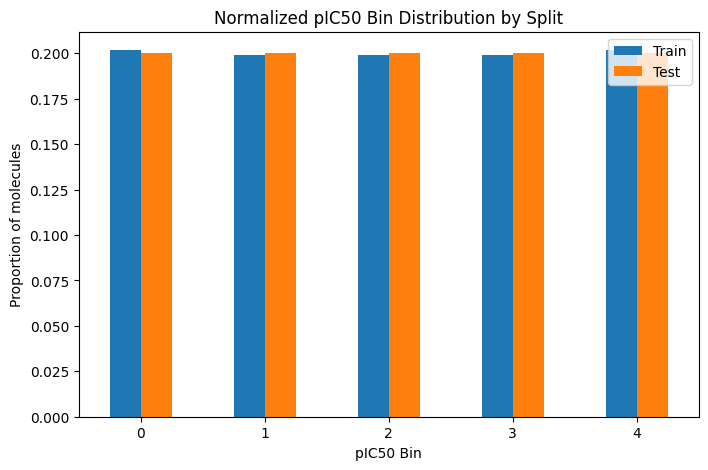

In [41]:
bin_counts, bin_props = analyze_bin_distribution(df_valid, train_idx, test_idx)

In [42]:
import matplotlib.pyplot as plt

def plot_scaffold_split_sizes(summary_df):
    summary_df_sorted = summary_df.sort_values('Total', ascending=False)
    summary_df_sorted[['Train', 'Test']].plot(kind='bar', stacked=True, figsize=(12,6))
    plt.xticks([])  # Hide x-axis labels
    plt.xlabel('Scaffolds (hidden)')
    plt.ylabel('Number of Molecules')
    plt.title('Molecule Counts per Scaffold by Split')
    plt.show()


In [43]:
import pandas as pd

def summarize_scaffold_split(df, train_idx, test_idx, smiles_col='smiles'):
    # Extract scaffolds
    scaffolds = df[smiles_col].apply(get_murcko_scaffold)
    df = df.copy()
    df['scaffold'] = scaffolds
    
    # Assign split label
    df['split'] = 'None'
    df.loc[train_idx, 'split'] = 'Train'
    df.loc[test_idx, 'split'] = 'Test'
    
    # Group by scaffold and split
    summary = df.groupby(['scaffold', 'split']).size().unstack(fill_value=0)
    
    # Add total per scaffold
    summary['Total'] = summary.sum(axis=1)
    return summary


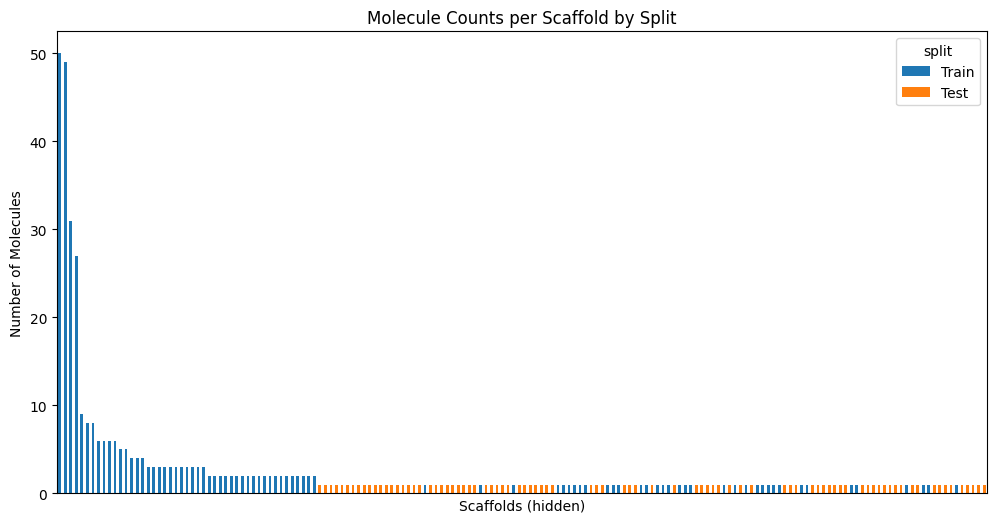

In [44]:
summary_df = summarize_scaffold_split(df, train_idx, test_idx)
plot_scaffold_split_sizes(summary_df)

In [45]:
# Verify zero scaffold overlap
train_scaffolds = set(df_train['scaffold'])
#val_scaffolds = set(df_val['scaffold'])
test_scaffolds = set(df_test['scaffold'])

#train_val_overlap = train_scaffolds.intersection(val_scaffolds)
train_test_overlap = train_scaffolds.intersection(test_scaffolds)
#val_test_overlap = val_scaffolds.intersection(test_scaffolds)

print("Scaffold Overlap Verification:")
#print(f"  Train-Val overlap: {len(train_val_overlap)} scaffolds")
print(f"  Train-Test overlap: {len(train_test_overlap)} scaffolds")
#print(f"  Val-Test overlap: {len(val_test_overlap)} scaffolds")

if len(train_test_overlap) == 0:
    print("\n[SUCCESS] Zero scaffold overlap - split integrity verified!")
else:
    print("\n[ERROR] Scaffold overlap detected - check implementation!")


Scaffold Overlap Verification:
  Train-Test overlap: 0 scaffolds

[SUCCESS] Zero scaffold overlap - split integrity verified!


In [46]:
# Analyze pIC50 distributions across splits
print("pIC50 Distribution Analysis:")
print(f"{'Partition':<10} {'Count':>8} {'Mean':>8} {'Std':>8} {'Min':>8} {'Max':>8}")
print("-" * 58)

for name, data in [('Train', df_train), ('Test', df_test)]:
    print(f"{name:<10} {len(data):>8,} {data['pIC50'].mean():>8.2f} {data['pIC50'].std():>8.2f} {data['pIC50'].min():>8.2f} {data['pIC50'].max():>8.2f}")

print("-" * 58)
print(f"{'Total':<10} {len(df_valid):>8,} {df_valid['pIC50'].mean():>8.2f} {df_valid['pIC50'].std():>8.2f} {df_valid['pIC50'].min():>8.2f} {df_valid['pIC50'].max():>8.2f}")


pIC50 Distribution Analysis:
Partition     Count     Mean      Std      Min      Max
----------------------------------------------------------
Train           337     6.57     1.18     4.41     9.70
Test             85     6.57     1.13     4.69     9.00
----------------------------------------------------------
Total           422     6.57     1.17     4.41     9.70


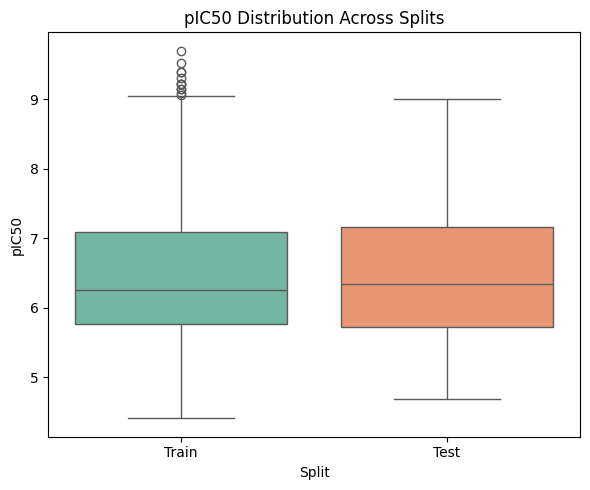

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data with labels
df_train['Split'] = 'Train'
#df_val['Split'] = 'Val'
df_test['Split'] = 'Test'
df_combined = pd.concat([df_train, df_test])

# Box plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_combined, x='Split', y='pIC50', hue='Split',
            order=['Train', 'Test'], palette='Set2', legend=False)
plt.title('pIC50 Distribution Across Splits')
plt.tight_layout()
plt.show()


In [48]:
# Create index mapping from SMILES to row position

df_ecfp4_final = pd.read_csv("data/DATASET_ecfp4.csv")
df_maccs_final = pd.read_csv("data/DATASET_maccs.csv")
df_rdkit_final = pd.read_csv("data/DATASET_rdkit.csv")
df_fingerprints_combined = pd.read_csv("data/DATASET_fp_combined.csv")

smiles_to_split = {}
for idx in train_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'train'
#for idx in val_idx:
#    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'val'
for idx in test_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'test'
 
def split_by_smiles(df, smiles_col='smiles'):
    """Split DataFrame using SMILES-based assignment."""
    df['split'] = df[smiles_col].map(smiles_to_split)
    train = df[df['split'] == 'train'].drop(columns=['split'])
    #val = df[df['split'] == 'val'].drop(columns=['split'])
    test = df[df['split'] == 'test'].drop(columns=['split'])
    return train, test
 
# Split all fingerprint datasets
fp_ecfp4_train, fp_ecfp4_test = split_by_smiles(df_ecfp4_final)
fp_maccs_train, fp_maccs_test = split_by_smiles(df_maccs_final)
fp_rdkit_train, fp_rdkit_test = split_by_smiles(df_rdkit_final)
fp_combined_train, fp_combined_test = split_by_smiles(df_fingerprints_combined)
 
print(f"ECFP4 split: train={len(fp_ecfp4_train)}, test={len(fp_ecfp4_test)}")
print(f"MACCS split: train={len(fp_maccs_train)}, test={len(fp_maccs_test)}")
print(f"RDKIT split: train={len(fp_rdkit_train)}, test={len(fp_rdkit_test)}")
print(f"Combined FP split: train={len(fp_combined_train)}, test={len(fp_combined_test)}")

ECFP4 split: train=337, test=85
MACCS split: train=337, test=85
RDKIT split: train=337, test=85
Combined FP split: train=337, test=85


In [49]:
# Split descriptor dataset
df_descriptors_rdkit = pd.read_csv("data/DATASET_descriptors_rdkit.csv")
desc_train_rdkit, desc_test_rdkit = split_by_smiles(df_descriptors_rdkit)
print(f"RDKit Descriptor split: train={len(desc_train_rdkit)}, test={len(desc_test_rdkit)}")

df_descriptors_mordred = pd.read_csv("data/DATASET_descriptors_mordred.csv")
desc_train_mordred, desc_test_mordred = split_by_smiles(df_descriptors_mordred)
print(f"Mordred Descriptor split: train={len(desc_train_mordred)}, test={len(desc_test_mordred)}")

RDKit Descriptor split: train=337, test=85
Mordred Descriptor split: train=337, test=85


In [50]:
import os

# Create splits directory
os.makedirs('splits', exist_ok=True)

# Save ECFP4 splits
fp_ecfp4_train.to_csv('splits/DATASET_ecfp4_train.csv', index=False)
#fp_ecfp4_val.to_csv('splits/DATASET_ecfp4_val.csv', index=False)
fp_ecfp4_test.to_csv('splits/DATASET_ecfp4_test.csv', index=False)

# Save MACCS splits
fp_maccs_train.to_csv('splits/DATASET_maccs_train.csv', index=False)
#fp_maccs_val.to_csv('splits/DATASET_maccs_val.csv', index=False)
fp_maccs_test.to_csv('splits/DATASET_maccs_test.csv', index=False)

# Save RDKit fingerprint splits
fp_rdkit_train.to_csv('splits/DATASET_rdkit_fp_train.csv', index=False)
#fp_rdkit_val.to_csv('splits/DATASET_rdkit_fp_val.csv', index=False)
fp_rdkit_test.to_csv('splits/DATASET_rdkit_fp_test.csv', index=False)

# Save combined fingerprint splits
fp_combined_train.to_csv('splits/DATASET_fingerprints_combined_train.csv', index=False)
#fp_combined_val.to_csv('splits/DATASET_fingerprints_combined_val.csv', index=False)
fp_combined_test.to_csv('splits/DATASET_fingerprints_combined_test.csv', index=False)

# Save descriptor splits
desc_train_rdkit.to_csv('splits/DATASET_descriptors_rdkit_train.csv', index=False)
#desc_val.to_csv('splits/DATASET_descriptors_val.csv', index=False)
desc_test_rdkit.to_csv('splits/DATASET_descriptors_rdkit_test.csv', index=False)

desc_train_mordred.to_csv('splits/DATASET_descriptors_mordred_train.csv', index=False)
#desc_val.to_csv('splits/DATASET_descriptors_val.csv', index=False)
desc_test_mordred.to_csv('splits/DATASET_descriptors_mordred_test.csv', index=False)

print("All split datasets saved to 'splits/' directory")
print(f"Files created: {len(os.listdir('splits'))}")


All split datasets saved to 'splits/' directory
Files created: 13



ECFP4:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

MACCS:
  Feature columns: 167
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

RDKit Fingerprints:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

Combined Fingerprints:
  Feature columns: 4263
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

RDKit Descriptors:
  Feature columns: 217
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85

Mordred Descriptors:
  Feature columns: 1505
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 337, Test: 85


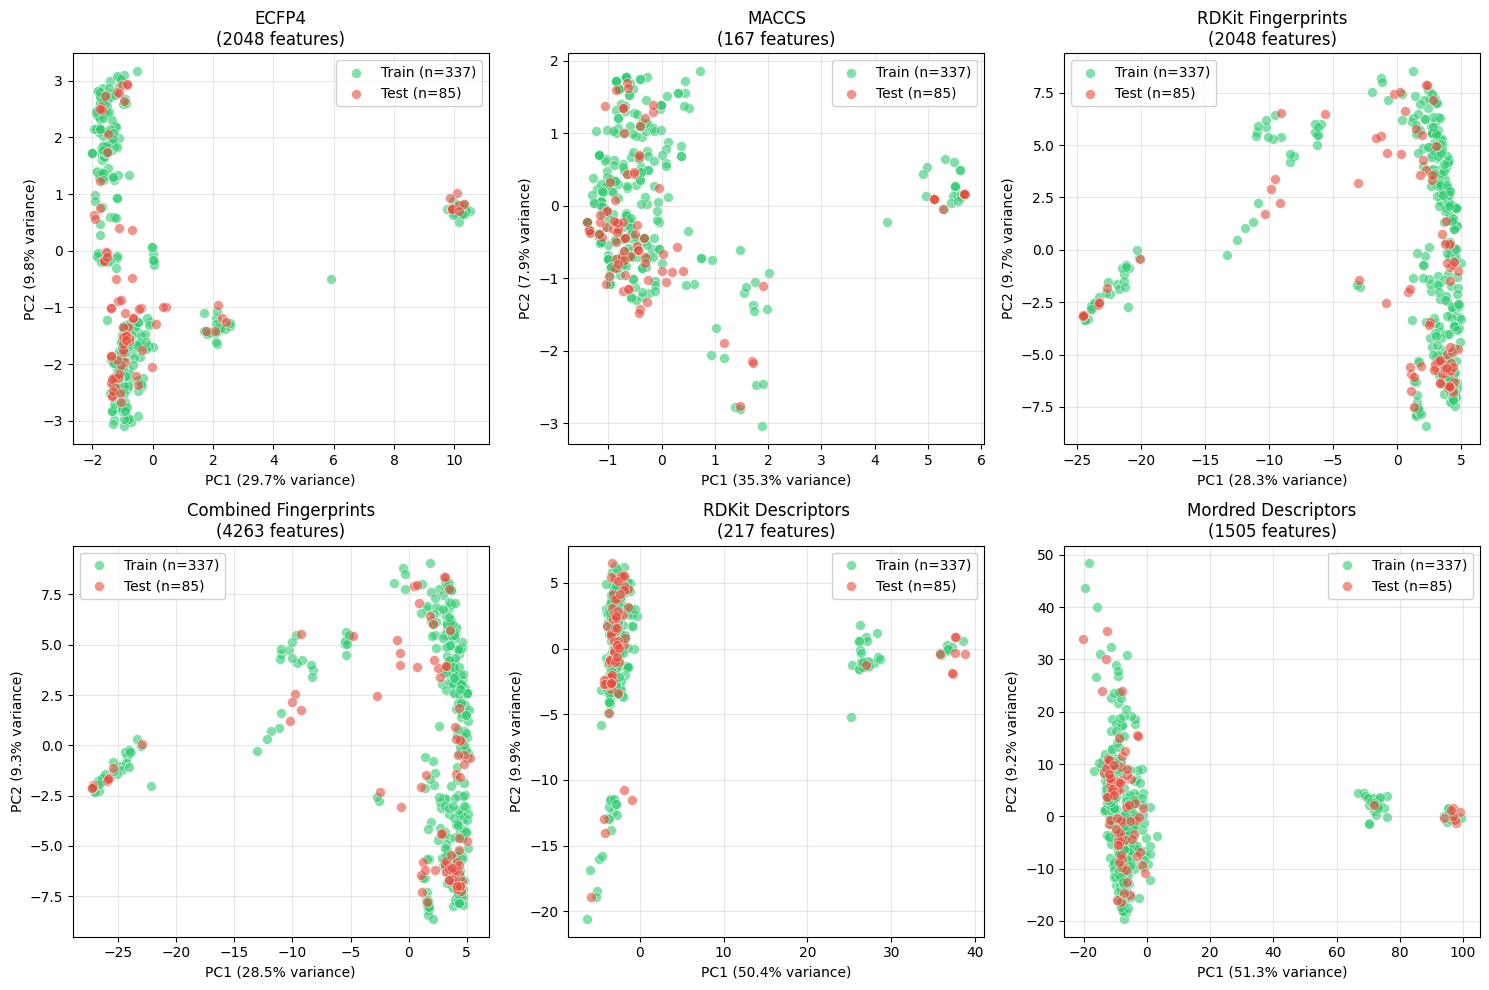

In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the 5 methods and their file prefixes
methods = {
    'ECFP4': 'DATASET_ecfp4',
    'MACCS': 'DATASET_maccs',
    'RDKit Fingerprints': 'DATASET_rdkit_fp',
    'Combined Fingerprints': 'DATASET_fingerprints_combined',
    'RDKit Descriptors': 'DATASET_descriptors_rdkit',
    'Mordred Descriptors': 'DATASET_descriptors_mordred'
}

# Columns to exclude (non-feature columns)
EXCLUDE_COLS = ['molecule_chembl_id', 'smiles', 'pIC50']

def detect_feature_columns(df):
    """
    Detect feature columns by excluding specified non-feature columns.
    """
    non_feature_cols = [col for col in df.columns if col in EXCLUDE_COLS]
    feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
    return feature_cols, non_feature_cols

def load_splits(file_prefix, splits_dir='splits'):
    """
    Load train, validation, and test splits for a given method.
    """
    train_df = pd.read_csv(f'{splits_dir}/{file_prefix}_train.csv')
    #val_df = pd.read_csv(f'{splits_dir}/{file_prefix}_val.csv')
    test_df = pd.read_csv(f'{splits_dir}/{file_prefix}_test.csv')
    return train_df, test_df

def plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=None):
    """
    Perform PCA and plot for train/val/test subsets of a given method.
    """
    # Load data
    train_df, test_df = load_splits(file_prefix, splits_dir)

    # Detect feature columns
    feature_cols, non_feature_cols = detect_feature_columns(train_df)

    print(f"\n{method_name}:")
    print(f"  Feature columns: {len(feature_cols)}")
    print(f"  Excluded columns: {non_feature_cols}")
    print(f"  Train: {len(train_df)}, Test: {len(test_df)}")

    # Extract features
    X_train = train_df[feature_cols].dropna(axis=1).values.astype(float)
    #X_val = val_df[feature_cols].values.astype(float)
    X_test = test_df[train_df[feature_cols].dropna(axis=1).columns].values.astype(float)

    # Only scale for Descriptors
    if "Descriptors" in method_name:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        #X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    # Perform PCA (fit on train, transform all)
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(X_train)
    #val_pca = pca.transform(X_val)
    test_pca = pca.transform(X_test)

    # Get explained variance
    var_explained = pca.explained_variance_ratio_ * 100

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.6, label=f'Train (n={len(train_df)})',
               c='#2ecc71', edgecolors='white', linewidth=0.5, s=50)
    #ax.scatter(val_pca[:, 0], val_pca[:, 1], alpha=0.6, label=f'Val (n={len(val_df)})',
    #           c='#3498db', edgecolors='white', linewidth=0.5, s=50)
    ax.scatter(test_pca[:, 0], test_pca[:, 1], alpha=0.6, label=f'Test (n={len(test_df)})',
               c='#e74c3c', edgecolors='white', linewidth=0.5, s=50)

    ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}% variance)')
    ax.set_title(f'{method_name}\n({len(feature_cols)} features)')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)

    return pca, var_explained

# Main execution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (method_name, file_prefix) in enumerate(methods.items()):
    plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=axes[idx])

plt.tight_layout()
plt.show()


In [1]:
#feature selection

import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_regression

fp_ecfp4_train = pd.read_csv("splits/DATASET_ecfp4_train.csv")
#fp_ecfp4_val = pd.read_csv("splits/DATASET_ecfp4_val.csv")
fp_ecfp4_test = pd.read_csv("splits/DATASET_ecfp4_test.csv")
fp_maccs_train = pd.read_csv("splits/DATASET_maccs_train.csv")
#fp_maccs_val = pd.read_csv("splits/DATASET_maccs_val.csv")
fp_maccs_test = pd.read_csv("splits/DATASET_maccs_test.csv")
fp_rdkit_train = pd.read_csv("splits/DATASET_rdkit_fp_train.csv")
#fp_rdkit_val = pd.read_csv("splits/DATASET_rdkit_fp_val.csv")
fp_rdkit_test = pd.read_csv("splits/DATASET_rdkit_fp_test.csv")
fp_combined_train = pd.read_csv("splits/DATASET_fingerprints_combined_train.csv")
#fp_combined_val = pd.read_csv("splits/DATASET_fingerprints_combined_val.csv")
fp_combined_test = pd.read_csv("splits/DATASET_fingerprints_combined_test.csv")
desc_rdkit_train = pd.read_csv("splits/DATASET_descriptors_rdkit_train.csv")
#desc_val = pd.read_csv("splits/DATASET_descriptors_val.csv")
desc_rdkit_test = pd.read_csv("splits/DATASET_descriptors_rdkit_test.csv")
desc_mordred_train = pd.read_csv("splits/DATASET_descriptors_mordred_train.csv")
#desc_val = pd.read_csv("splits/DATASET_descriptors_val.csv")
desc_mordred_test = pd.read_csv("splits/DATASET_descriptors_mordred_test.csv")

feature_groups = {
    "ECFP4": (fp_ecfp4_train, fp_ecfp4_test),
    "MACCS": (fp_maccs_train, fp_maccs_test),
    "RDKit": (fp_rdkit_train, fp_rdkit_test),
    "CombinedFP": (fp_combined_train, fp_combined_test),
    "RDKit_Descriptors": (desc_rdkit_train, desc_rdkit_test),
    "Mordred_Descriptors": (desc_mordred_train, desc_mordred_test)
}


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class clean_features(BaseEstimator, TransformerMixin):
    """
    Remove features with more than 10% missing values

    Returns: list of features to keep
    """
    def __init__(self):
        self.to_keep_ = []

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Remove descriptors with >10% missing values
        missing_counts = X.isna().sum()
        valid_features = missing_counts[missing_counts <= len(X) * 0.1].index.tolist()
        self.to_keep_ = valid_features

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X_filtered = X[self.to_keep_].copy()
        return X_filtered


In [3]:
class remove_correlated_features(BaseEstimator, TransformerMixin):
    """
    Remove highly correlated features from a DataFrame.

    For each pair with |correlation| > threshold, removes the
    feature with higher mean absolute correlation to all others.

    Parameters:
    - threshold: correlation threshold (default 0.95)

    Returns: list of features to keep
    """
    def __init__(self, threshold = 0.95):
        self.threshold = threshold
        self.to_drop_ = []

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Calculate correlation matrix
        corr_matrix = X.corr().abs()

        target_corr = X.corrwith(y).abs()

        # Get upper triangle (avoid duplicate pairs)
        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )

        for col in upper_tri.columns:
            # Find features correlated above threshold with this column
            correlated = upper_tri.index[upper_tri[col] > self.threshold].tolist()
            for corr_feat in correlated:
                # Keep feature with lower mean correlation
                if target_corr[col] > target_corr[corr_feat]:
                    self.to_drop_.append(corr_feat)
                else:
                    self.to_drop_.append(col)
        self.to_drop_ = list(set(self.to_drop_))
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        kept_columns = [c for c in X.columns if c not in self.to_drop_]
        X_filtered = X[kept_columns].copy()
        return X_filtered


In [ ]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel, VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import numpy as np
import warnings

# Suppress LightGBM specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
# Suppress the specific 'X does not have valid feature names' warning often seen in Pipelines
warnings.filterwarnings("ignore", category=UserWarning, message=".*X does not have valid feature names.*")

# ==============================
# Cross-validation setup
# ==============================

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# ==============================
# Storage
# ==============================

results = {}
target_col = "pIC50"
metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50']

models_dict = {
    "RF": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'),
    "XGB": XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=3,subsample=1.0,colsample_bytree=1.0,reg_lambda=0.0,reg_alpha=1.0,objective="reg:squarederror",random_state=42,n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=100,learning_rate=0.1,num_leaves=31,random_state=42,n_jobs=-1,importance_type='gain', verbose=-1),
}

# ==============================
# Loop over feature groups
# ==============================

for model in models_dict:
    print(f"\n=== Baseline {model} model ===")
    baseline = models_dict[model]

    for name, (train_df, test_df) in feature_groups.items():
        print(f"Running Baseline Model for : {name}")

        feature_cols = [c for c in train_df.columns if c not in metadata_cols]
        X_train = train_df[feature_cols]
        y_train = train_df[target_col]

        if "Descriptors" in name:
            # For Descriptors: Scale then Select (Best for Lasso)
            imputer = SimpleImputer(strategy='median')
            correlation = remove_correlated_features(0.95)
            scaler = StandardScaler()
            selector = SelectFromModel(LassoCV(cv=cv, max_iter=50000, n_jobs=-1, random_state=42))
            
            steps = [
                ("clean", clean_features()),
                ("imputer", imputer),
                ("variance_threshold", VarianceThreshold(0.01)),
                ("correlation_filter", correlation),
                ("scaler", scaler), 
                ("feature_selection", selector),
                ("model", baseline)
            ]
        else: 
            imputer = SimpleImputer(strategy='constant', fill_value=0)
            correlation = 'passthrough' 
            selector = SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=100)
            scaler = StandardScaler() # Optional, but recommended for SVR fairness

            steps = [
                ("clean", clean_features()),
                ("imputer", imputer),
                ("variance_threshold", VarianceThreshold(0.01)),
                ("correlation_filter", correlation),
                ("feature_selection", selector), 
                ("scaler", scaler),
                ("model", baseline)
            ]

        pipeline = Pipeline(steps)

        scores = cross_val_score(
            pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )

        y_pred = cross_val_predict(pipeline, X_train, y_train, cv=cv)
        q2 = r2_score(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        rmse_mean = -scores.mean()
        rmse_std = scores.std()

        pipeline.fit(X_train, y_train)  # Fit on training data
        train_r2 = pipeline.score(X_train, y_train)  # R² on training data

        metrics = {'R2': train_r2, 'Q2': q2, 'CV RMSE mean': rmse_mean, 'CV RMSE std': rmse_std, 'RMSE': rmse, 'MAE': mae}

        results[f'baseline_train_{model}_{name}'] = metrics

        print(f"{'Train':15} R²={train_r2:.3f}  Q²(10 fold CV)={q2:.3f}  RMSE(10 fold CV)={rmse:.3f}  RMSE (Mean)={rmse_mean:.3f}  RMSE (Std)={rmse_std}  MAE(10 fold CV)={mae:.3f}")

        joblib.dump(baseline, f'models/baseline_{model}_{name}.joblib')        


=== Baseline LightGBM model ===
Running Baseline Model for : ECFP4
Train           R²=0.823  Q²(10 fold CV)=0.703  RMSE(10 fold CV)=0.641  RMSE (Mean)=0.639  RMSE (Std)=0.06210767578248803  MAE(10 fold CV)=0.491
Running Baseline Model for : MACCS
Train           R²=0.686  Q²(10 fold CV)=0.522  RMSE(10 fold CV)=0.814  RMSE (Mean)=0.809  RMSE (Std)=0.08336393078905992  MAE(10 fold CV)=0.590
Running Baseline Model for : RDKit
Train           R²=0.758  Q²(10 fold CV)=0.606  RMSE(10 fold CV)=0.739  RMSE (Mean)=0.731  RMSE (Std)=0.1071177169441786  MAE(10 fold CV)=0.543
Running Baseline Model for : CombinedFP
Train           R²=0.829  Q²(10 fold CV)=0.654  RMSE(10 fold CV)=0.692  RMSE (Mean)=0.688  RMSE (Std)=0.08169038033910644  MAE(10 fold CV)=0.520
Running Baseline Model for : RDKit_Descriptors
Train           R²=0.944  Q²(10 fold CV)=0.639  RMSE(10 fold CV)=0.708  RMSE (Mean)=0.703  RMSE (Std)=0.08146963850139148  MAE(10 fold CV)=0.526
Running Baseline Model for : Mordred_Descriptors
Tr

In [12]:
results

{'baseline_train_LightGBM_ECFP4': {'R2': 0.8233078080450955,
  'Q2': 0.7032411735546675,
  'CV RMSE mean': 0.6388471518493356,
  'CV RMSE std': 0.06210767578248803,
  'RMSE': 0.6413212440753759,
  'MAE': 0.4914371821309478},
 'baseline_train_LightGBM_MACCS': {'R2': 0.6862753016755679,
  'Q2': 0.5223924893772783,
  'CV RMSE mean': 0.8090972750703147,
  'CV RMSE std': 0.08336393078905992,
  'RMSE': 0.8135970734296135,
  'MAE': 0.5904148656877857},
 'baseline_train_LightGBM_RDKit': {'R2': 0.7583459788510226,
  'Q2': 0.6057940465404241,
  'CV RMSE mean': 0.7312134309717984,
  'CV RMSE std': 0.1071177169441786,
  'RMSE': 0.7391547860720893,
  'MAE': 0.5430640229380015},
 'baseline_train_LightGBM_CombinedFP': {'R2': 0.8292986651341124,
  'Q2': 0.6543872001023117,
  'CV RMSE mean': 0.6877248075514226,
  'CV RMSE std': 0.08169038033910644,
  'RMSE': 0.6920997829938581,
  'MAE': 0.519933752609658},
 'baseline_train_LightGBM_RDKit_Descriptors': {'R2': 0.9436364333746307,
  'Q2': 0.63877963780490

In [70]:
#save results so no need to rerun next time
df = pd.DataFrame.from_dict(results, orient='index')

# Optional: reset index to make model names a column
df = df.reset_index().rename(columns={'index': 'Model'})

# Save to CSV
df.to_csv("data/model_metrics.csv", index=False)

In [71]:
df = pd.read_csv("data/model_metrics.csv")
df

,Model,R2,Q2,CV RMSE mean,CV RMSE std,RMSE,MAE
0,baseline_train_LightGBM_ECFP4,0.823308,0.703241,0.638847,0.062108,0.641321,0.491437
1,baseline_train_LightGBM_MACCS,0.686275,0.522392,0.809097,0.083364,0.813597,0.590415
2,baseline_train_LightGBM_RDKit,0.758346,0.605794,0.731213,0.107118,0.739155,0.543064
3,baseline_train_LightGBM_CombinedFP,0.829299,0.654387,0.687725,0.081690,0.692100,0.519934
4,baseline_train_LightGBM_RDKit_Descriptors,0.943636,0.638780,0.703082,0.081470,0.707555,0.525619
5,baseline_train_LightGBM_Mordred_Descriptors,0.978911,0.668849,0.667335,0.117630,0.677465,0.497467
6,baseline_train_RF_ECFP4,0.902060,0.704539,0.633465,0.093986,0.639917,0.482426
7,baseline_train_RF_MACCS,0.844938,0.588005,0.747803,0.107911,0.755649,0.558975
8,baseline_train_RF_RDKit,0.845513,0.607965,0.730921,0.093194,0.737116,0.540798
9,baseline_train_RF_CombinedFP,0.903185,0.664611,0.679430,0.055725,0.681786,0.503720


In [13]:
#reading from saved file (if needed)

import pandas as pd

df = pd.read_csv("data/model_metrics.csv")

# Set Model as index
df = df.set_index("Model")

# Convert back to nested dict
prev_results = df.to_dict(orient="index")

ECFP4 fingerprints performed the best for all baseline models in terms of 10 fold CV Q2, especially for XGB and SVR. CombinedFP also performed well for XGB and SVR. We will focus on optimising these 2 feature / model combinations.

As an additional exploration, we will also be looking at combining the better performing fingerprint and descriptor feature groups (ECFP4 fingerprints + Mordred descriptors) to see if performance improves.

Finally, we will be doing a simple MLP model and transfer learning on GNN model to verify performance


In [52]:
# explore fingerprint + descriptors model (redo feature selection on concatenated features)

scaler = StandardScaler()

metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50']
metadata = [metadata_cols]
target_col = "pIC50"
desc_feature_cols = [c for c in desc_mordred_train.columns if c not in metadata_cols]
fp_feature_cols = [c for c in fp_ecfp4_train.columns if c not in metadata_cols]

X_desc_train = desc_mordred_train[desc_feature_cols]
y_desc_train = desc_mordred_train[target_col]
X_desc_test = desc_mordred_test[desc_feature_cols]
y_desc_test = desc_mordred_test[target_col]

X_fp_train = fp_ecfp4_train[fp_feature_cols]
X_fp_test = fp_ecfp4_test[fp_feature_cols]

X_train = pd.concat([X_fp_train, X_desc_train], axis=1)
X_test   = pd.concat([X_fp_test, X_desc_test],   axis=1)

y_train = desc_mordred_train[target_col]
y_test = desc_mordred_test[target_col]

combined_train = pd.concat([pd.DataFrame(metadata), X_train, y_train], axis=1)
combined_test = pd.concat([pd.DataFrame(metadata), X_test, y_test], axis=1)

print("Combined feature shape:", X_train.shape)
print("Combined target shape:", y_train.shape)
print("Combined shape:", combined_train.shape)

Combined feature shape: (337, 3553)
Combined target shape: (337,)
Combined shape: (337, 3557)


In [53]:
# As we are relying on y values from descriptors only, check that both are in same order

metadata_desc = desc_mordred_train[metadata_cols]
metadata_fp = fp_ecfp4_train[metadata_cols]
are_identical = metadata_desc.equals(metadata_fp)
print("Both DataFrames are identical:", are_identical)

Both DataFrames are identical: True


In [54]:
combined_train.to_csv("splits/DATASET_descriptors_fp_train.csv", index=False)
combined_test.to_csv("splits/DATASET_descriptors_fp_test.csv", index=False)

In [ ]:
feature_groups["mixed"] = (combined_train, combined_test)

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest

n_descriptors = X_desc_train.shape[1]
n_fingerprints = X_fp_train.shape[1]

fingerprint_indices = list(range(0, n_fingerprints))
descriptor_indices = list(range(n_fingerprints, n_descriptors+n_fingerprints))

for model in models_dict:
    print(f"\n=== Baseline {model} model for mixed model ===")

    descriptor_pipe = Pipeline([
        ('clean', clean_features()),
        ("imputer", SimpleImputer(strategy='median')),
        ("variance_threshold", VarianceThreshold(0.01)),
        ("correlation_filter", remove_correlated_features(0.95)),
        ('scaler', StandardScaler()),
        ('lasso_select', SelectFromModel(LassoCV(cv=cv, max_iter=50000, n_jobs=-1, random_state=42))),
    ])

    fingerprint_pipe = Pipeline([
        ("clean", clean_features()),
        ("imputer", SimpleImputer(strategy='median')),
        ("variance_threshold", VarianceThreshold(0.01)),
        ('kbest_select', SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=100)),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('desc', descriptor_pipe, descriptor_indices),
            ('fp', fingerprint_pipe, fingerprint_indices)
        ]
    )

    baseline_model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', models_dict[model])
    ])

    scores = cross_val_score(
            baseline_model,
            X_train,
            y_train,
            cv=cv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )

    y_pred = cross_val_predict(baseline_model, X_train, y_train, cv=cv)
    q2 = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    rmse_mean = -scores.mean()
    rmse_std = scores.std()

    baseline_model.fit(X_train, y_train)  # Fit on training data
    train_r2 = baseline_model.score(X_train, y_train)  # R² on training data

    metrics = {'R2': train_r2, 'Q2': q2, 'CV RMSE mean': rmse_mean, 'CV RMSE std': rmse_std, 'RMSE': rmse, 'MAE': mae}

    results[f'baseline_train_{model}_mixed'] = metrics

    print(f"{'Train':15} R²={train_r2:.3f}  Q²(10 fold CV)={q2:.3f}  RMSE(10 fold CV)={rmse:.3f}  RMSE (Mean)={rmse_mean:.3f}  RMSE (Std)={rmse_std}  MAE(10 fold CV)={mae:.3f}")

    joblib.dump(baseline, f'models/baseline_{model}_mixed.joblib') 


=== Baseline RF model for mixed model ===
Train           R²=0.960  Q²(10 fold CV)=0.699  RMSE(10 fold CV)=0.646  RMSE (Mean)=0.642  RMSE (Std)=0.0744369618631694  MAE(10 fold CV)=0.482

=== Baseline SVR model for mixed model ===
Train           R²=0.873  Q²(10 fold CV)=0.704  RMSE(10 fold CV)=0.640  RMSE (Mean)=0.636  RMSE (Std)=0.06976794306700307  MAE(10 fold CV)=0.487

=== Baseline XGB model for mixed model ===
Train           R²=0.955  Q²(10 fold CV)=0.688  RMSE(10 fold CV)=0.657  RMSE (Mean)=0.651  RMSE (Std)=0.09062772224611121  MAE(10 fold CV)=0.497

=== Baseline LightGBM model for mixed model ===
Train           R²=0.977  Q²(10 fold CV)=0.689  RMSE(10 fold CV)=0.656  RMSE (Mean)=0.650  RMSE (Std)=0.08995940239764748  MAE(10 fold CV)=0.488


In [20]:
def mi_reproducible(X, y):
    return mutual_info_regression(X, y, random_state=42)

In [ ]:
import optuna
from optuna.samplers import TPESampler
import numpy as np
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

# --- XGBOOST OBJECTIVE ---
def objective_xgb(trial, X, y, mode):

    # --- 1. Base Parameters (General Speed & Reliability) ---
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.07, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist" # Optimization for high-dimensional ECFP4
    }

    # --- 2. Conditional Search Space based on Mode ---
    if mode == "ECFP4":
        # Using your "Zoomed-In" ECFP4 Grid
        params.update({
            "max_depth": trial.suggest_int("max_depth", 4, 8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 0.2), # Your winner!
            "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 5.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 5.0, log=True),
        })
        # Note: No SelectKBest here; colsample_bytree is doing the selection.
        k = "passthrough" 
        
    elif mode == "CombinedFP":
        # Strategy: Smooth out with higher lambda and lower depth
        params.update({
            "max_depth": trial.suggest_int("max_depth", 3, 5),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.7),
            "reg_lambda": trial.suggest_float("reg_lambda", 10, 50),
            "min_child_weight": trial.suggest_int("min_child_weight", 5, 20),
        })
        k = "passthrough"
        
    elif mode == "mixed":
        # Balanced logic
        params.update({
            "max_depth": trial.suggest_int("max_depth", 3, 7),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 30.0, log=True),
        })
        k = trial.suggest_int("k_hybrid", 200, 1000)

    # --- 3. The Pipeline ---
    select_k = SelectKBest(f_regression, k=k) if isinstance(k, int) else "passthrough"
    
    pipeline = Pipeline([
        ("variance", VarianceThreshold(0.01)),
        ("select", select_k),
        ("model", xgb.XGBRegressor(**params))
    ])
    
    return cross_val_score(pipeline, X, y, cv=cv, scoring='r2').mean()
'''
    params = {
        # High n_estimators with early stopping is ideal, 
        # but for Optuna CV, we focus on the range that worked.
        "n_estimators": trial.suggest_int("n_estimators", 500, 1200),
        
        # Zooming in: Depth 6 was best, let's try 4 to 8.
        "max_depth": trial.suggest_int("max_depth", 4, 8), 
        
        # Zooming in on the 0.03-0.05 range
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.07, log=True),
        
        # Stronger L1/L2 Search: 
        # Your winners used 0.6 - 1.5. Let's explore that neighborhood.
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 5.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 5.0, log=True),
        
        # Subsample: 0.6 seemed stable
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        
        # Crucial: Keep this low based on your winning Trial 41
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 0.2), 
        
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist" # Faster for large feature sets like ECFP4
    }
    
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='constant', fill_value=0)),
        ("variance", VarianceThreshold(0.01)),
        ("model", xgb.XGBRegressor(**params))
    ])
    return cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1).mean()
'''
# --- SVR OBJECTIVE ---
def objective_svr(trial, X, y, mode):
    # --- 1. Your Zoomed-In Grid ---
    params = {
        "C": trial.suggest_float("C", 1.0, 15.0),
        "epsilon": trial.suggest_float("epsilon", 0.05, 0.25),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "cache_size": 1000 # Speeds up training by using more RAM
    }

    # --- 2. Conditional Feature Selection ---
    if mode == "ECFP4":
        # Fingerprints are sparse; we need a tighter selection to avoid noise
        k = trial.suggest_int("k_ecfp4", 50, 300)
        score_func = f_regression # Use mutual_info_regression for more complexity
        
    elif mode == "CombinedFP":
        # Hybrid data is denser; SVR can handle more features here
        k = trial.suggest_int("k_combined", 100, 500)
        score_func = f_regression
        
    elif mode == "mixed":
        # Allow the model to explore a wider range of feature counts
        k = trial.suggest_int("k_hybrid", 50, 600)
        score_func = f_regression

    # --- 3. The Pipeline (Scaling is MANDATORY for SVR) ---
    pipeline = Pipeline([
        ("variance", VarianceThreshold(0.01)),
        ("select", SelectKBest(score_func=score_func, k=k)),
        ("scaler", StandardScaler()), # SVR fails without this
        ("model", SVR(**params))
    ])
    
    return cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1).mean()

    '''params = {
        # Zooming in on the 1.0 - 15.0 range
        "C": trial.suggest_float("C", 1.0, 15.0),
        
        # Zooming in on the epsilon range that worked
        "epsilon": trial.suggest_float("epsilon", 0.05, 0.25),
        
        # 'scale' is the clear winner, but we can try 
        # small variations around it if you want to be exhaustive.
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"])
    }
    
    # Tightening feature selection based on the 150-175 sweet spot
    k_features = trial.suggest_int("k_best", 120, 185)
    
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='constant', fill_value=0)),
        ("variance", VarianceThreshold(0.01)),
        ("select", SelectKBest(score_func=mi_reproducible, k=k_features)),
        ("scaler", StandardScaler()),
        ("model", SVR(kernel='rbf', **params))
    ])
    return cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1).mean()
'''
# --- EXECUTION ---

target_col = "pIC50"
metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50']
studies = {}

for model in ["XGB", "SVR"]:
    for feature in ["ECFP4", "CombinedFP", "mixed"]:
        train_df, test_df = feature_groups[feature]

        feature_cols = [c for c in train_df.columns if c not in metadata_cols]
        # Optimize XGBoost
        print(f"Optimizing {model} for {feature}...")
        study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
        study.optimize(lambda t: objective_xgb(t, train_df[feature_cols], train_df[target_col], feature), n_trials=50)

        studies[f'{model}_{feature}'] = study

In [66]:
def get_final_metrics(study, model_type, data, feature):

    train_df, test_df = data

    feature_cols = [c for c in train_df.columns if c not in metadata_cols]
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    best_params = study.best_params
    
    # Build specific pipeline
    if model_type == "XGB":
        model = xgb.XGBRegressor(**best_params, random_state=42)
        steps = [("imputer", SimpleImputer(strategy='constant', fill_value=0)),
                 ("variance", VarianceThreshold(0.01)),
                 ("model", model)]
    else:
        k = best_params.pop('k_best')
        model = SVR(kernel='rbf', **best_params)
        steps = [("imputer", SimpleImputer(strategy='constant', fill_value=0)),
                 ("variance", VarianceThreshold(0.01)),
                 ("select", SelectKBest(score_func=mi_reproducible, k=k)),
                 ("scaler", StandardScaler()),
                 ("model", model)]
    
    pipeline = Pipeline(steps)
    
    # Get CV predictions (Q2)
    y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=cv)

     # Train on full set for R2 and Test set evaluation
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Re-run CV for stability stats
    rmse_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
    rmse_mean = abs(rmse_scores.mean())
    rmse_std = rmse_scores.std()
    
    # Store results
    train_metrics = {
        'R2': r2_score(y_train, y_pred_train),
        'Q2': r2_score(y_train, y_pred_cv),
        'CV RMSE mean': rmse_mean,
        'CV RMSE std': rmse_std,
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_cv)),
        'MAE': mean_absolute_error(y_train, y_pred_cv)
    }
    
    test_metrics = {
        'R2': r2_score(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE': mean_absolute_error(y_test, y_pred_test)
    }
    
    # Update global results dict
    results[f"optimised_train_{model_type}_{feature}"] = train_metrics
    results[f"optimised_test_{model_type}_{feature}"] = test_metrics

    # Compare against baseline (Assuming the baseline key exists)
    base_key = f'baseline_train_{model_type}_{feature}'
    if base_key in results:
        improvement = r2_score(y_train, y_pred_cv) - results[base_key]['Q2']
        print(f"\n--- {model_type} Optimization Results ---")
        print(f"Improvement: {improvement:+.4f}")
        print(f"Test R²:     {test_metrics['R2']:.4f}")

In [ ]:
for model in ["XGB", "SVR"]:
    for feature in ["ECFP4", "CombinedFP", "mixed"]
        get_final_metrics(studies[feature], model, feature_groups[feature], feature)


--- XGB Optimization Results ---
Improvement: +0.0461
Test R²:     0.6301

--- SVR Optimization Results ---
Improvement: +0.0358
Test R²:     0.6225


In [10]:
# Create comprehensive summary table
summary_data = []
 
model_configs = [
    ('Random Forest (RDKit FP) - Baseline', 'RF_RDKit_baseline'),
    ('Random Forest (RDKit FP) - Optimized', 'RF_RDKit_optimized'),
    ('XGB (RDKit FP) - Baseline', 'XGB_RDKit_baseline'),
    ('XGB (RDKit FP) - Optimized', 'XGB_RDKit_optimized'),
    ('LightGBM (RDKit FP) - Baseline', 'LightGBM_RDKit_baseline'),
    ('LightGBM (RDKit FP) - Optimized', 'LightGBM_RDKit_optimized'),
    ('SVR (RDKit FP and Descriptors) - Baseline', 'SVR_RDKit_Descriptors_baseline'),
    ('SVR (RDKit FP and Descriptors) - Optimized', 'SVR_RDKit_Descriptors_optimized')
]

for name, prefix in model_configs:
    if f'{prefix}_test' in results:
        summary_data.append({
            'Model': name,
            'Train R²': results[f'{prefix}_trainval']['R2'],
            #'Val R²': results[f'{prefix}_val']['R2'],
            'Test R²': results[f'{prefix}_test']['R2'],
            #'Val RMSE': results[f'{prefix}_val']['RMSE'],
            'Test RMSE': results[f'{prefix}_test']['RMSE'],
            #'Val MAE': results[f'{prefix}_val']['MAE'],
            'Test MAE': results[f'{prefix}_test']['MAE'],
        })
 
df_summary = pd.DataFrame(summary_data)
 
print("=" * 90)
print("MODEL COMPARISON SUMMARY")
print("=" * 90)
print(df_summary.to_string(index=False))
print("=" * 90)


MODEL COMPARISON SUMMARY
                               Model  Train R²  Test R²  Test RMSE  Test MAE
Random Forest (RDKit FP) - Optimized  0.943910 0.513489   0.885472  0.635058
          XGB (RDKit FP) - Optimized  0.976564 0.551502   0.850176  0.614343
     LightGBM (RDKit FP) - Optimized  0.927915 0.709254   0.684519  0.513873


In [33]:
import os

os.makedirs('reports', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [35]:
import joblib
import os
 
# Save Random Forest models
joblib.dump(rf_baseline, 'models/rf_baseline.joblib')
joblib.dump(rf_optimized, 'models/rf_optimized.joblib')
 
# Save SVR models
joblib.dump(svr_baseline, 'models/svr_baseline.joblib')
joblib.dump(svr_optimized, 'models/svr_optimized.joblib')
 
# Save GridSearchCV objects (contains full search history)
joblib.dump(rf_grid_search, 'models/rf_gridsearch_cv.joblib')
joblib.dump(svr_grid_search, 'models/svr_gridsearch_cv.joblib')
 
print("All models saved to 'models/' directory:")
for f in sorted(os.listdir('models')):
    print(f"  {f}")


All models saved to 'models/' directory:
  .DS_Store
  rf_baseline.joblib
  rf_gridsearch_cv.joblib
  rf_optimized.joblib
  svr_baseline.joblib
  svr_gridsearch_cv.joblib
  svr_optimized.joblib


In [ ]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(selected_features.items()), columns=['Feature', 'Value'])
# Save as CSV
df.to_csv('models/selected_features.csv', index=False)

In [ ]:
import json
 
# Compile best parameters
best_params_summary = {
    'random_forest_baseline': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': rf_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-rf_grid_search.best_score_)),
        'test_r2': float(results['RF_CombinedFP_baseline_test']['R2']),
        'test_rmse': float(results['RF_CombinedFP_baseline_test']['RMSE'])
    },
    'svr_optimized': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': svr_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-svr_grid_search.best_score_)),
        'test_r2': float(results['SVR_optimized_test']['R2']),
        'test_rmse': float(results['SVR_optimized_test']['RMSE'])
    }
}

# Save as JSON
with open('models/best_parameters.json', 'w') as f:
    json.dump(best_params_summary, f, indent=2)
 
print("Best parameters saved to: models/best_parameters.json")
print("\nContents:")
print(json.dumps(best_params_summary, indent=2))


Best parameters saved to: models/best_parameters.json

Contents:
{
  "random_forest_baseline": {
    "representation": "Combined FP (ECFP4, MACCS, RDKit)",
    "parameters": {
      "max_depth": null,
      "max_features": "sqrt",
      "min_samples_leaf": 1,
      "min_samples_split": 2,
      "n_estimators": 200
    },
    "cv_rmse": 0.6604613558697207,
    "test_r2": 0.5598683849305361,
    "test_rmse": 0.8422094140040617
  },
  "svr_optimized": {
    "representation": "Combined FP (ECFP4, MACCS, RDKit)",
    "parameters": {
      "C": 10.0,
      "epsilon": 0.5,
      "gamma": "auto"
    },
    "cv_rmse": 0.6631408902926731,
    "test_r2": 0.5745119710506136,
    "test_rmse": 0.8280803548828019
  }
}
